# Load data + basic cleaning + South Africa boundary

In [4]:
import geodatasets

keys = list(geodatasets.data.keys())
cand = [k for k in keys if ("admin" in k.lower()) or ("country" in k.lower()) or ("countries" in k.lower())]
cand[:50], len(cand)

([], 0)

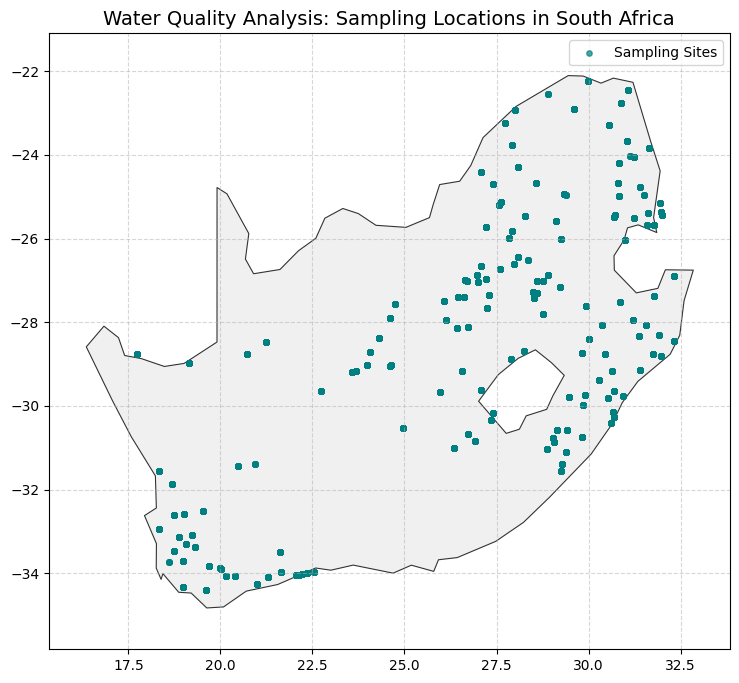

In [13]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

# 1) Load your water quality training data
WQ_TRAIN_PATH = "water_quality_training_dataset.csv"
df = pd.read_csv(WQ_TRAIN_PATH)
df.columns = [c.strip() for c in df.columns]

TARGETS = ["Total Alkalinity", "Electrical Conductance", "Dissolved Reactive Phosphorus"]
for c in ["Latitude", "Longitude"] + TARGETS:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df = df.dropna(subset=["Latitude", "Longitude"] + TARGETS).copy()

gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["Longitude"], df["Latitude"]),
    crs="EPSG:4326"
)

# 2) South Africa boundary - THE FAILSAFE WAY
# We'll use the official Natural Earth direct link to avoid geodatasets issues
url = "https://raw.githubusercontent.com/nvkelso/natural-earth-vector/master/geojson/ne_110m_admin_0_countries.geojson"
world = gpd.read_file(url)

# This specific dataset uses 'NAME' (uppercase)
# We use a case-insensitive check just to be safe
sa = world[world['NAME'].str.contains("South Africa", na=False)].to_crs("EPSG:4326")

# 3) Plotting setup
if not sa.empty:
    minx, miny, maxx, maxy = sa.total_bounds
    padx, pady = 1.0, 1.0 
    xlim = (minx - padx, maxx + padx)
    ylim = (miny - pady, maxy + pady)
    
    fig, ax = plt.subplots(figsize=(12, 8))
    sa.plot(ax=ax, color='#f0f0f0', edgecolor='#333333', linewidth=0.8)
    gdf.plot(ax=ax, color='teal', markersize=15, alpha=0.7, label='Sampling Sites')
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    plt.title("Water Quality Analysis: Sampling Locations in South Africa", fontsize=14)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()
else:
    print("Could not find South Africa in the map data. Try printing world.columns to see available names.")

# Heatmap for each feature (hexbin heatmap + colorbar + SA outline)

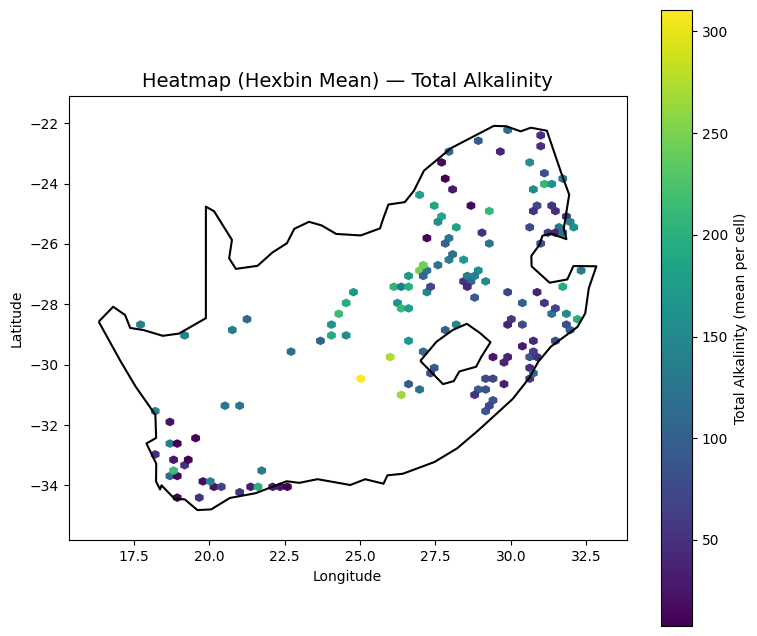

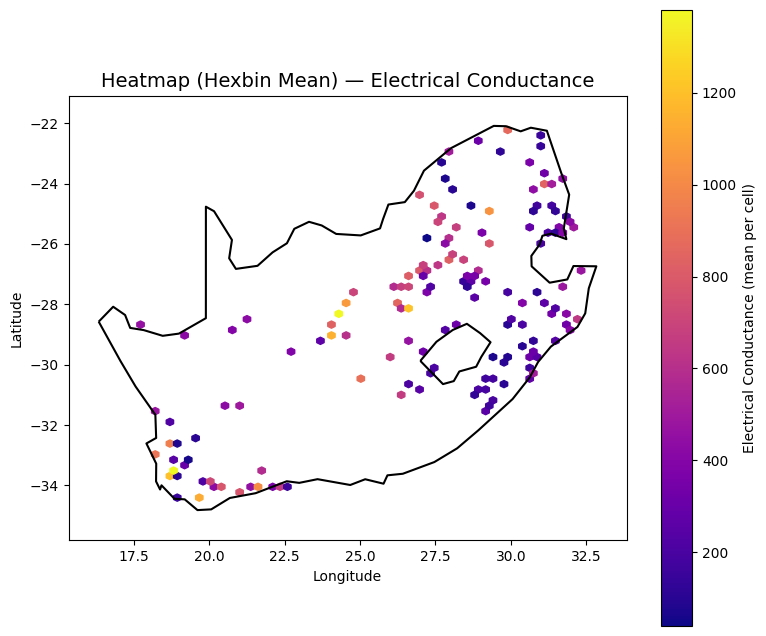

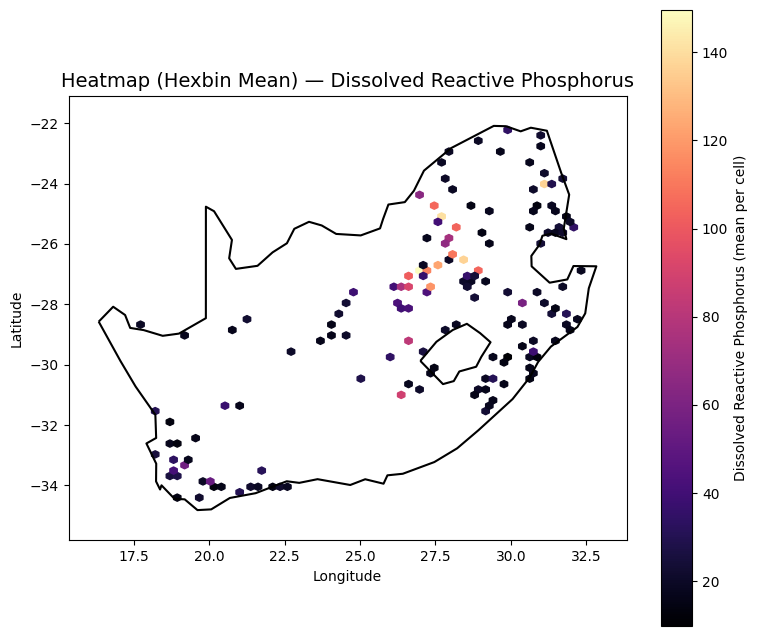

In [14]:
def plot_feature_heatmap_hexbin(gdf, sa, feature, gridsize=60, cmap="viridis"):
    fig, ax = plt.subplots(figsize=(9, 8))

    # draw South Africa boundary
    sa.boundary.plot(ax=ax, linewidth=1.5, color="black")

    # hexbin heatmap (weighted by feature values)
    hb = ax.hexbin(
        gdf["Longitude"], gdf["Latitude"],
        C=gdf[feature],
        reduce_C_function=np.mean,   # mean value per hex cell
        gridsize=gridsize,
        cmap=cmap,
        mincnt=1
    )

    ax.set_title(f"Heatmap (Hexbin Mean) — {feature}", fontsize=14)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.set_aspect("equal", adjustable="box")

    cbar = fig.colorbar(hb, ax=ax)
    cbar.set_label(f"{feature} (mean per cell)")

    plt.show()

# ---- plot 3 heatmaps ----
plot_feature_heatmap_hexbin(gdf, sa, "Total Alkalinity", gridsize=60, cmap="viridis")
plot_feature_heatmap_hexbin(gdf, sa, "Electrical Conductance", gridsize=60, cmap="plasma")
plot_feature_heatmap_hexbin(gdf, sa, "Dissolved Reactive Phosphorus", gridsize=60, cmap="magma")


# “3 files” version

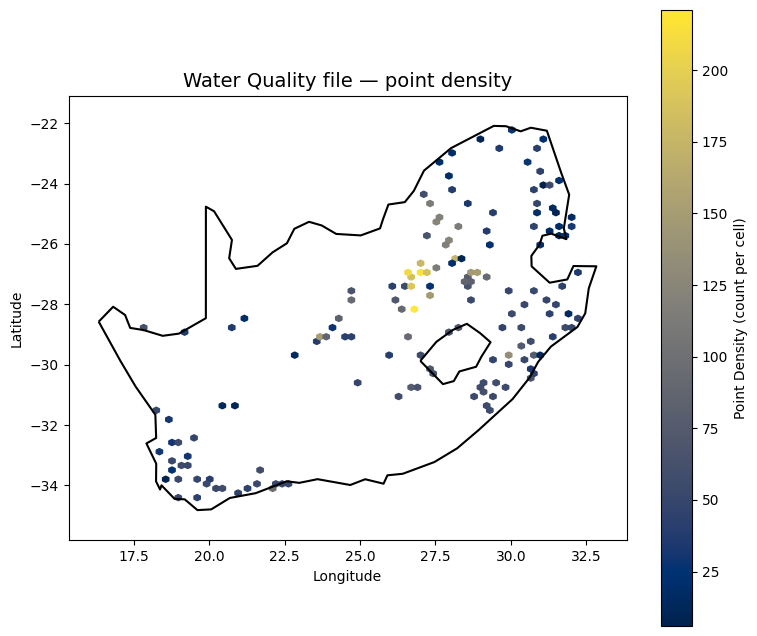

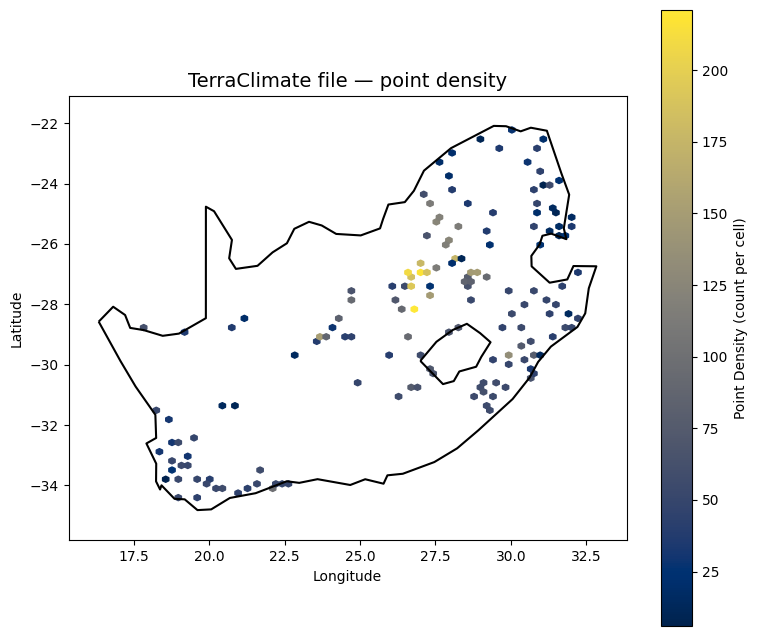

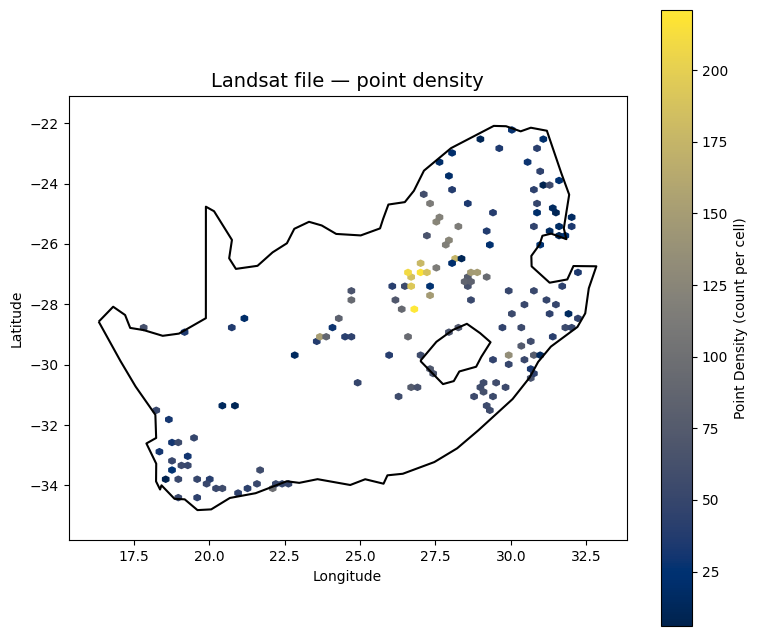

In [15]:
# CHANGE filenames if yours differ
TC_TRAIN_PATH = "terraclimate_features_training.csv"
LS_TRAIN_PATH = "landsat_features_training.csv"

def load_feature_file(path):
    d = pd.read_csv(path)
    d.columns = [c.strip() for c in d.columns]
    d["Latitude"] = pd.to_numeric(d["Latitude"], errors="coerce")
    d["Longitude"] = pd.to_numeric(d["Longitude"], errors="coerce")
    d = d.dropna(subset=["Latitude", "Longitude"]).copy()
    return d

wq = df.copy()
tc = load_feature_file(TC_TRAIN_PATH)
ls = load_feature_file(LS_TRAIN_PATH)

def plot_point_density(gdf_like, sa, title, gridsize=70, cmap="cividis"):
    fig, ax = plt.subplots(figsize=(9, 8))
    sa.boundary.plot(ax=ax, linewidth=1.5, color="black")

    hb = ax.hexbin(
        gdf_like["Longitude"], gdf_like["Latitude"],
        gridsize=gridsize,
        cmap=cmap,
        mincnt=1
    )
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.set_aspect("equal", adjustable="box")

    cbar = fig.colorbar(hb, ax=ax)
    cbar.set_label("Point Density (count per cell)")
    plt.show()

plot_point_density(wq, sa, "Water Quality file — point density")
plot_point_density(tc, sa, "TerraClimate file — point density")
plot_point_density(ls, sa, "Landsat file — point density")

# Combined map (Alkal + EC + DRP) with labels + colors + legend

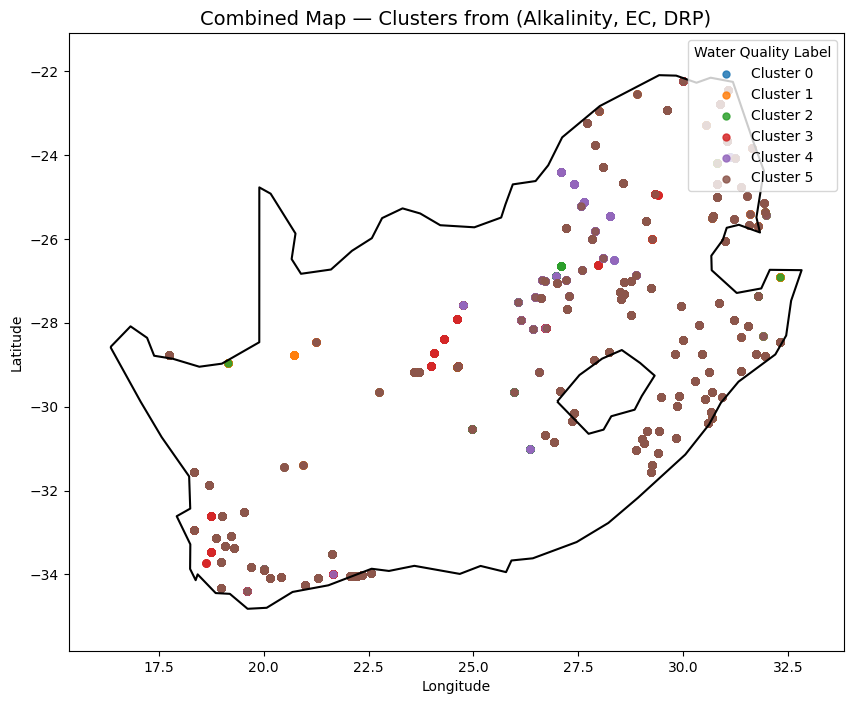

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Build matrix for clustering
X = gdf[TARGETS].values
X = StandardScaler().fit_transform(X)

# Choose number of clusters (labels) — tune this (4–8 is usually good)
K = 6
km = KMeans(n_clusters=K, random_state=42, n_init=10)
gdf["WQ_Cluster"] = km.fit_predict(X)

# Build readable labels
cluster_labels = {i: f"Cluster {i}" for i in range(K)}
gdf["WQ_Label"] = gdf["WQ_Cluster"].map(cluster_labels)

# Plot combined clusters
fig, ax = plt.subplots(figsize=(10, 9))
sa.boundary.plot(ax=ax, linewidth=1.5, color="black")

# categorical colors
cats = sorted(gdf["WQ_Label"].unique())
colors = plt.cm.tab10(np.linspace(0, 1, max(10, len(cats))))  # up to 10 distinct
color_map = {c: colors[i % len(colors)] for i, c in enumerate(cats)}

for c in cats:
    sub = gdf[gdf["WQ_Label"] == c]
    ax.scatter(
        sub["Longitude"], sub["Latitude"],
        s=25, alpha=0.85,
        color=color_map[c],
        label=c
    )

ax.set_title("Combined Map — Clusters from (Alkalinity, EC, DRP)", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_xlim(*xlim)
ax.set_ylim(*ylim)
ax.set_aspect("equal", adjustable="box")

ax.legend(title="Water Quality Label", loc="upper right", frameon=True)
plt.show()